# Enunciado Problema 1

## Descripción


En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él. El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.


## Dataset


El dataset proporcionado incluye las siguientes variables para cada estudiante:

- Hours Studied: El número total de horas dedicadas al estudio por cada estudiante.
- Previous Scores: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
- Extracurricular Activities: Si el estudiante participa en actividades extracurriculares (Sí o No).
- Sleep Hours: El número promedio de horas de sueño que el estudiante tuvo por día.
- Sample Question Papers Practiced: El número de cuestionarios de muestra que el estudiante practicó.

Además, el dataset incluye la variable objetivo:

- Performance Index: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.


## Objetivo

Utilizando el dataset proporcionado, el objetivo es construir un modelo de regresión utilizando redes neuronales que pueda predecir con precisión el índice de rendimiento académico de los estudiantes. Se debe entrenar y evaluar el modelo utilizando técnicas adecuadas de validación y métricas de evaluación de regresión.


## Entrega


La entrega debe incluir:
- Código fuente de la solución implementada en Google Colab, que incluya:
    - Análisis previo y preprocesamiento del set de datos.
    - Definición y entrenamiento del modelo.
    - Resultados de la evaluación del modelo, incluyendo métricas de desempeño y visualizaciones relevantes.

Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.

# Resolución

## Configuracion

### Entorno

In [ ]:
import zipfile
import os
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Datos

In [ ]:
student_performance = '1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc'

!gdown $student_performance

with zipfile.ZipFile('TP1-1-student_performance.zip', 'r') as zip_ref:
    if not os.path.exists('/content/'):
        os.makedirs('/content/')

    zip_ref.extractall('/content/')

!rm 'TP1-1-student_performance.zip'

Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100% 49.7k/49.7k [00:00<00:00, 74.2MB/s]


In [ ]:
df = pd.read_csv('/content/Student_Performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [ ]:
!rm '/content/Student_Performance.csv'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [ ]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

### Depuración

In [ ]:
map_bools = lambda x: 1 if x == 'Yes' else 0

df["Extracurricular Activities"] = df["Extracurricular Activities"].apply(map_bools)

In [ ]:
display(df.head(3))
print('\n')
display(df.info())

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  int64  
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 468.9 KB


None

In [ ]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

## Analisis

### Primer modelo base

In [ ]:
df_train, df_val = train_test_split(df, train_size=0.7, random_state=1)

In [ ]:
X_train = df_train.drop('performance_index', axis=1)
y_train = df_train['performance_index']

X_val = df_val.drop('performance_index', axis=1)
y_val = df_val['performance_index']

In [ ]:
y_train.head()

2228    66.0
5910    52.0
1950    30.0
2119    83.0
5947    78.0
Name: performance_index, dtype: float64

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_scaled = scaler.transform(np.array(y_val).reshape(-1, 1))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.fit(X_train_scaled, y_train_scaled)

# Evaluate the model
loss, mse = model.evaluate(X_val_scaled, y_val_scaled)
y_pred_scaled = model.predict(X_val_scaled)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_val = scaler.inverse_transform(y_val_scaled)

94/94 [==============================] - 0s 2ms/step


In [ ]:
r2 = r2_score(y_val, y_pred)

print('Loss:', loss)
print('Mean squared error:', mse)
print('R²:', r2)

Loss: 0.559968888759613
Mean squared error: 0.559968888759613
R²: 0.4278405626498756


### Investigacion

In [ ]:
df_train_scaled = pd.concat(
                            [
                            pd.DataFrame(X_train_scaled, columns=df_train.drop('performance_index', axis=1).columns),
                            pd.Series(y_train_scaled.flatten(), name='performance_index')
                            ],
                            axis=1
                            )

display(df_train_scaled.head(2))

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,sample_question_papers_practiced,performance_index
0,-0.394381,0.904253,-0.982159,0.275538,0.144458,0.562235
1,-1.166810,0.443852,-0.982159,1.462107,-1.254168,-0.164167


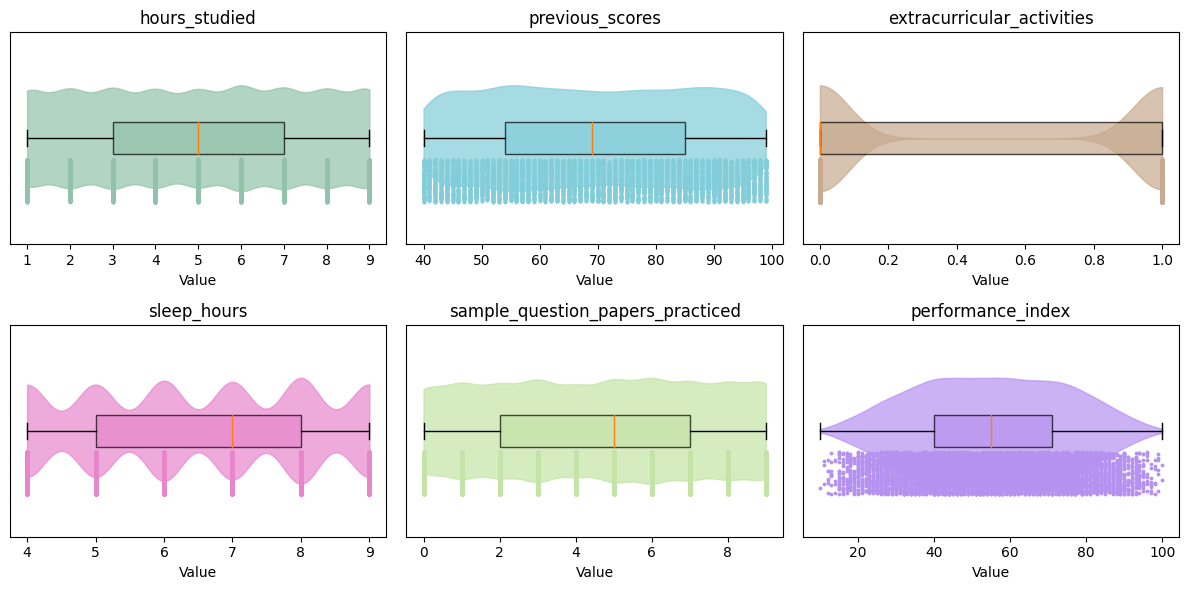

<Figure size 640x480 with 0 Axes>

In [ ]:

def plot_boxplot(df, cols: list[str]=[], figsize: tuple = (18, 12), max_cols : int=6 ,
                 scatter:bool=True,
                 violin:bool= True,
                 violin_args: dict = {},
                 boxplot_args: dict = {}):

    default_violin_args = {
         "points": 500,
         "showmeans": False,
         "showextrema": False,
         "showmedians":False,
         "vert":False
    }

    default_boxplot_args = {
        "patch_artist": True,
        "vert":False
    }

    violin_args = {**default_violin_args, **violin_args}
    boxplot_args = {**default_boxplot_args, **boxplot_args}

    cols = cols if cols else list(df.columns)

    # Generate random colors
    random_colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
         for i in range(len(cols))]

    # Convert random colors to pastel colors
    pastel_colors = []
    for color in random_colors:
        r, g, b = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        pastel_r = (r + 256) // 2
        pastel_g = (g + 256) // 2
        pastel_b = (b + 256) // 2
        pastel_color = '#{:02x}{:02x}{:02x}'.format(pastel_r, pastel_g, pastel_b)
        pastel_colors.append(pastel_color)

    n_rows = int(len(cols)/max_cols) + (len(cols)%max_cols>0)
    n_cols = max_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    plt.figure()

    for idx, column in enumerate(cols):
        ax = axes[idx // n_cols, idx % n_cols]

        bp = ax.boxplot(df[column], **boxplot_args)
        bp['boxes'][0].set_facecolor(pastel_colors[idx])
        bp['boxes'][0].set_alpha(0.7)

        if violin:
            vp = ax.violinplot(df[column], **violin_args)
            vp['bodies'][0].set_color(pastel_colors[idx])
            vp['bodies'][0].set_alpha(0.7)

        if scatter:
            y = np.full(len(df[column]), 0.8) + np.random.uniform(low=-.1, high=.1, size=len(df[column]))
            ax.scatter(df[column], y, s=3, c=pastel_colors[idx])

        ax.set_title(column)
        ax.set_yticks([])
        ax.set_xlabel("Value")

    fig.tight_layout()
    plt.show()

plot_boxplot(df_train, cols=[ c for c in df_train.columns if c != "Class" ], max_cols=3, figsize=(12, 6))


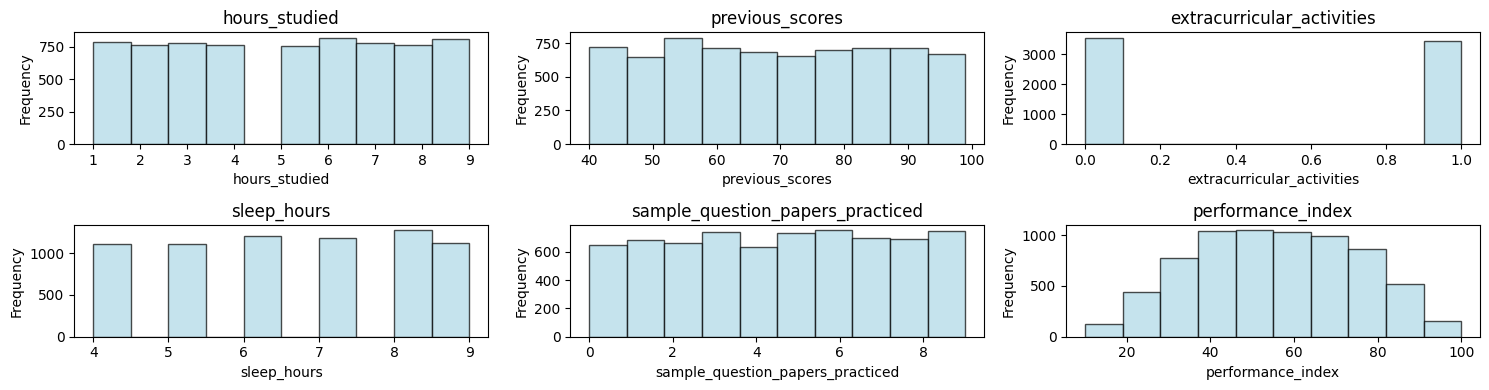

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 4))

axs = axs.flatten()
for i, column in enumerate(df_train.columns):
    axs[i].hist(df_train[column], color='lightblue', edgecolor='black', alpha=0.7)  # Create histogram with pastel colors and transparency
    axs[i].set_title(column)  # Set the title for each subplot
    axs[i].set_xlabel(column)  # Set x-label
    axs[i].set_ylabel('Frequency')  # Set y-label

plt.tight_layout()
plt.show()


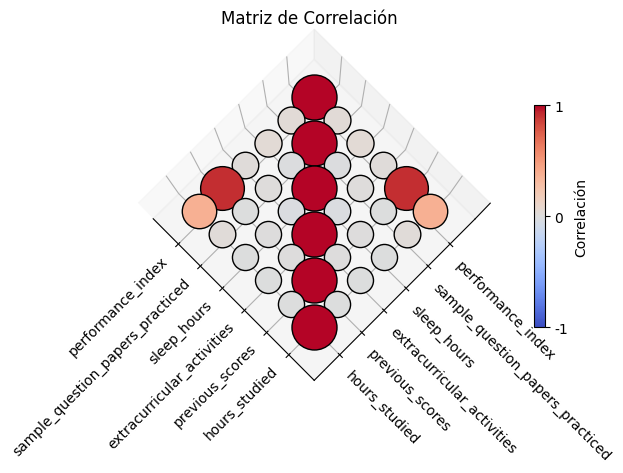

In [ ]:
corr = df_train_scaled.corr()

# Obtener las coordenadas (x, y, z) para las esferas
x, y = np.meshgrid(range(corr.shape[0]), range(corr.shape[1]))
z = np.zeros_like(x)

# Obtener los valores de correlación
correlation_values = corr.values.flatten()

# Configurar la figura de matplotlib en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Obtener los tamaños de las esferas de acuerdo a las correlaciones
sizes = np.abs(correlation_values) + 0.5  # Agregar 0.5 para asegurar que las correlaciones nulas sean visibles

# Crear las esferas para cada correlación con una escala de colores
norm = plt.Normalize(-1, 1)
cmap = cm.get_cmap('coolwarm')
colors = cmap(norm(correlation_values))

# Crear las esferas para cada correlación con su color y tamaño correspondientes
for i, (xi, yi, zi) in enumerate(zip(x.flatten(), y.flatten(), z.flatten())):
    correlation = correlation_values[i]
    color = colors[i]
    size = sizes[i]
    ax.scatter(xi, yi, zi, color=color, s=size * 700, edgecolor='black')

# Configurar los límites y etiquetas de los ejes
ax.set_xlim([-1, corr.shape[0]])
ax.set_ylim([-1, corr.shape[1]])

# Ajustar el rango del eje z
z_range = np.nanmax(np.abs(correlation_values))
ax.set_zlim([-z_range, z_range])
ax.set_xticks(range(corr.shape[0]))
ax.set_yticks(range(corr.shape[1]))
ax.set_zticks([])
ax.set_xticklabels(corr.columns, ha='right', va='center', rotation=45, rotation_mode='anchor')
ax.set_yticklabels(corr.columns, ha='right', va='top', rotation=-45, rotation_mode='anchor')

# Ajustar la inclinación del gráfico
ax.view_init(elev=-95, azim=45)

# Agregar la barra de leyenda
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(correlation_values)
cbar = fig.colorbar(mappable, pad=0.08, shrink=0.6, ticks=[-1, 0, 1])
cbar.set_label('Correlación')
cbar.ax.yaxis.set_major_locator(FixedLocator([-1, 0, 1]))
cbar.ax.yaxis.set_major_formatter(FixedFormatter(['-1', '0', '1']))

# Ajustar la posición de los tick labels en el eje x y eje y
for tick_label_x, tick_label_y in zip(ax.xaxis.get_majorticklabels(), ax.yaxis.get_majorticklabels()):
    tick_label_x.set_bbox({'facecolor': 'white', 'pad': 0.1, 'edgecolor': 'none'})
    tick_label_x.set_horizontalalignment('right')

    tick_label_y.set_bbox({'facecolor': 'white', 'pad': 0.1, 'edgecolor': 'none'})
    tick_label_y.set_horizontalalignment('left')
# agregar titulo
plt.title('Matriz de Correlación')

clear_output()
plt.show()

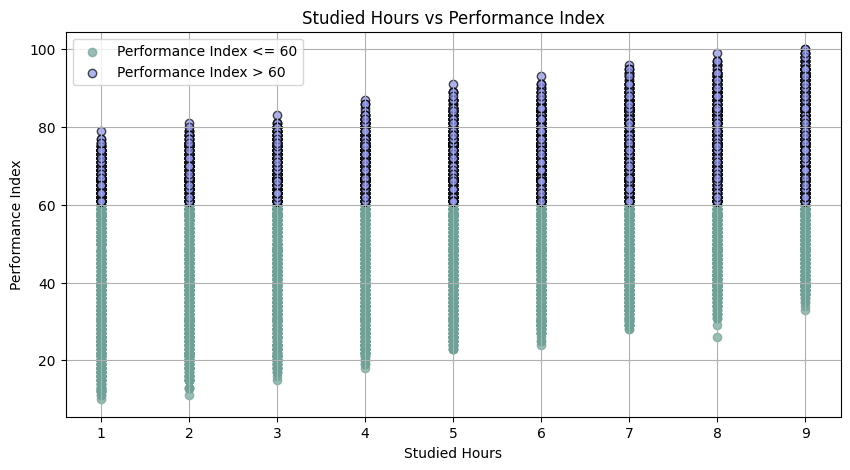

In [ ]:
# Generate distinct pastel colors
def generate_pastel_color(high_contrast=True):
    if high_contrast:
        return tuple((np.random.rand(3) * 0.6) + 0.4)  # Generate a high-contrast pastel color
    else:
        return tuple((np.random.rand(3) + 1) / 2)  # Generate a more muted, whitened pastel color

# Scatter plot comparing studied hours with performance index
plt.figure(figsize=(10, 5))

# Plot for students with performance index <= 60
plt.scatter(df_train[df_train['performance_index'] <= 60]['hours_studied'],
            df_train[df_train['performance_index'] <= 60]['performance_index'],
            color=generate_pastel_color(high_contrast=True),
            label='Performance Index <= 60',
            alpha=0.7,
            )

# Plot for students with performance index > 60
plt.scatter(df_train[df_train['performance_index'] > 60]['hours_studied'],
            df_train[df_train['performance_index'] > 60]['performance_index'],
            color=generate_pastel_color(high_contrast=False),
            label='Performance Index > 60',
            alpha=0.7,
            edgecolor='black')

plt.title('Studied Hours vs Performance Index')
plt.xlabel('Studied Hours')
plt.ylabel('Performance Index')
plt.legend()
plt.grid(True)

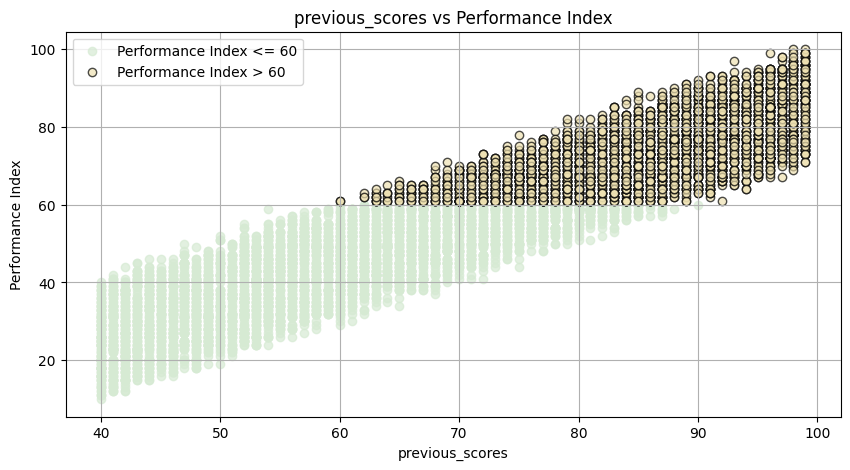

In [ ]:
# Generate distinct pastel colors
def generate_pastel_color(high_contrast=True):
    if high_contrast:
        return tuple((np.random.rand(3) * 0.6) + 0.4)  # Generate a high-contrast pastel color
    else:
        return tuple((np.random.rand(3) + 1) / 2)  # Generate a more muted, whitened pastel color

# Scatter plot comparing studied hours with performance index
plt.figure(figsize=(10, 5))

# Plot for students with performance index <= 60
plt.scatter(df_train[df_train['performance_index'] <= 60]['previous_scores'],
            df_train[df_train['performance_index'] <= 60]['performance_index'],
            color=generate_pastel_color(high_contrast=True),
            label='Performance Index <= 60',
            alpha=0.7,
            )

# Plot for students with performance index > 60
plt.scatter(df_train[df_train['performance_index'] > 60]['previous_scores'],
            df_train[df_train['performance_index'] > 60]['performance_index'],
            color=generate_pastel_color(high_contrast=False),
            label='Performance Index > 60',
            alpha=0.7,
            edgecolor='black')

plt.title('previous_scores vs Performance Index')
plt.xlabel('previous_scores')
plt.ylabel('Performance Index')
plt.legend()
plt.grid(True)

## Modelo formal

### Hiper parametros

### Evaluacion

### Explicabilidad

## Conclusion